# Mini-projet n°1 – Chats ou Chiens ?

In [3]:
#Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, clone_model, Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16 


2025-12-17 13:01:25.895657: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-17 13:01:25.944215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 13:01:41.868514: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [8]:
df = pd.read_csv(
    "./oxford-iiit-pet/annotations/list.txt",
    sep=r"\s+",                                         
    comment="#",                                        
    header=None,                                        
    names=["Image", "CLASS_ID", "SPECIES", "BREED_ID"]
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7349 entries, 0 to 7348
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Image     7349 non-null   object
 1   CLASS_ID  7349 non-null   int64 
 2   SPECIES   7349 non-null   int64 
 3   BREED_ID  7349 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 229.8+ KB


Le jeu de données est composé de 7349 individus.
Les variables sont les suivantes :
- Image : au format .jpg ;
- CLASS\_ID (race) : 37 races différentes ;
- SPECIES : chat ou chien (1 ou 2 selon l'espèce) ;
- BREED\_ID : identifiant de la race parmi l'espèce concernée.

Afin de rendre les données plus lisibles, nous rajoutons deux variables non numériques précisant les noms de l'espèce (SPECIES\_NAME) et de la race (BREED\_NAME) de chaque individu.

In [9]:
df["BREED_NAME"] = df["Image"].str.rsplit("_", n=1).str[0]           # Nom de la race
df["SPECIES_NAME"] = df["SPECIES"].map({1: "Cat", 2: "Dog"})         # Chat ou chien
df["Image"] = df["Image"].apply(lambda x: f"{x}.jpg")

print(df.sample(n=3, random_state=42))

                      Image  CLASS_ID  SPECIES  BREED_ID      BREED_NAME  \
2755       keeshond_164.jpg        19        2        13        keeshond   
2966   newfoundland_178.jpg        23        2        16    newfoundland   
5186  great_pyrenees_31.jpg        16        2        10  great_pyrenees   

     SPECIES_NAME  
2755          Dog  
2966          Dog  
5186          Dog  


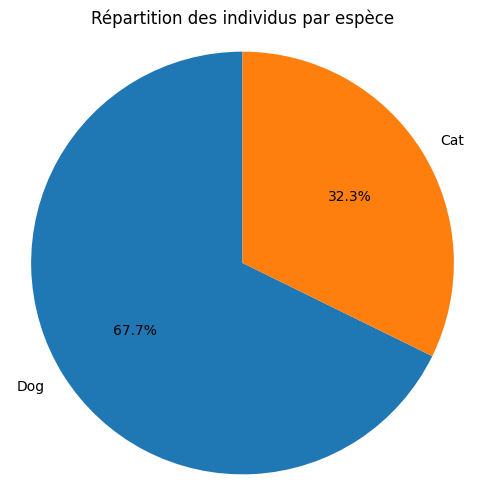

In [12]:
species_counts = df["SPECIES_NAME"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    species_counts.values,
    labels=species_counts.index,
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Répartition des individus par espèce")
plt.axis("equal")
plt.show()

67.7 % des individus du jeu de données sont des chiens et 32.3% sont des chats


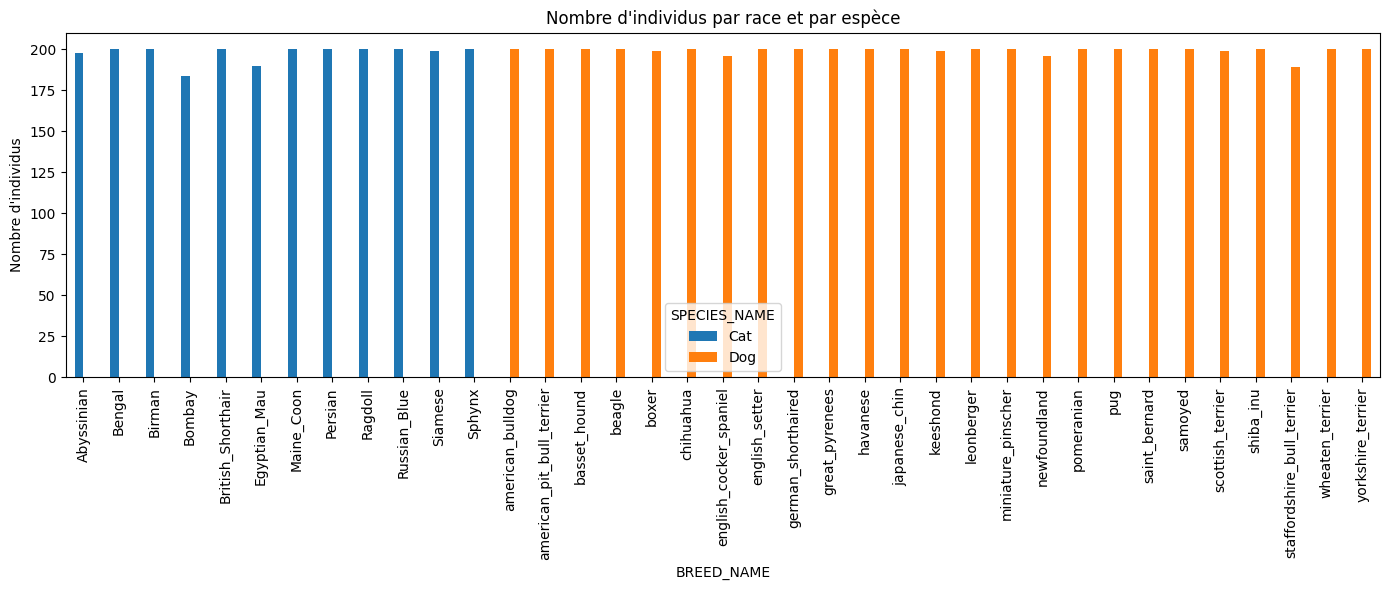

In [13]:
pivot = pd.pivot_table(
    df,
    index="BREED_NAME",
    columns="SPECIES_NAME",
    values="Image",
    aggfunc="count"
)

pivot.plot(
    kind="bar",
    figsize=(14, 6)
)

plt.ylabel("Nombre d'individus")
plt.title("Nombre d'individus par race et par espèce")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Le nombre d'individus est environ le même pour chaque race (200). Les données semblent a priori équilibré,  même si certaines races (Bombay, chat) n'ont pas autant d'individus que les autres.
On peut conclure cette sous-partie en avançant que les données sont suffisament bien réparties selon les espèces et les races. Il y a une légère sur-représentations des chiens, et les races sont légèrement déséquilibrés, mais cela ne devrait pas être impactant pour la suite.

### Classification binaire

en gros ici on veut savoir si on arrive bien a retrouver les chats et les chiens 

In [ ]:

# --- Configuration des chemins (A ajuster selon votre dossier) ---
base_path = "./oxford-iiit-pet/"
img_dir = os.path.join(base_path, "images/")
mask_dir = os.path.join(base_path, "annotations/trimaps/")

# --- Ajout de la colonne des masques ---
# Les masques portent le même nom que l'image, mais en .png
# Votre colonne 'Image' contient déjà l'extension .jpg, on doit la remplacer
df['mask_filename'] = df['Image'].str.replace('.jpg', '.png')

# Vérification que les fichiers existent (optionnel mais recommandé)
# df = df[df['Image'].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))]

# --- Division du Dataset (Train / Val / Test) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['SPECIES_NAME'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['SPECIES_NAME'])

print(f"Train: {len(train_df)} | Validation: {len(val_df)} | Test: {len(test_df)}")

Found 4703 validated image filenames belonging to 2 classes.
Found 1176 validated image filenames belonging to 2 classes.
Found 1470 validated image filenames belonging to 2 classes.


In [ ]:
batch_size = 20  # doit être un diviseur de N_train and N_validation (20 est bien un diviseur de 5200 et 1000, c'est pour ça qu'on a pris des valeurs rondes pour N_train et N_validation)
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    img_dir,
    x_col = 'Image',
    y_col = 'SPECIES_NAME',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size)

Ce code configure le pipeline de préparation des données pour la classification binaire (Chats vs Chiens). Il définit d'abord les hyperparamètres structurels, fixant la résolution des images à 150×150 pixels et la taille des lots (batch_size) à 20, une valeur choisie pour diviser exactement le nombre total d'échantillons. Trois instances d'ImageDataGenerator sont ensuite créées pour les ensembles d'entraînement, de validation et de test, appliquant uniquement une normalisation des pixels (rescale=1./255) pour ramener leurs valeurs dans l'intervalle [0,1]. La méthode flow_from_dataframe est utilisée pour générer les flux de données en associant les fichiers images du répertoire img_dir (colonne 'Image') à leurs étiquettes cibles (colonne 'SPECIES_NAME'). Enfin, le paramètre class_mode='binary' est spécifié pour encoder les étiquettes en format binaire, adaptant ainsi les données à une sortie à deux classes.

### CNN Simple

In [ ]:
def cnn_simple(nom):
    # Initialisation du modèle Séquentiel (les couches s'empilent les unes après les autres)
    cnn = Sequential(name=nom)
    
    # Couche d'entrée : définit la taille attendue des images (Largeur, Hauteur, 3 canaux RGB)
    cnn.add(Input(shape=(img_width, img_height, 3)))

    # --- BLOC 1 : Détection de traits simples (lignes, couleurs) ---
    # 32 filtres pour commencer léger. Activation ReLU pour casser la linéarité.
    cnn.add(Conv2D(32, (3,3), activation='relu'))
    # Réduit la taille spatiale par 2 (ex: 150 -> 75 pixels) pour garder l'essentiel
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 2 : Détection de textures ---
    # On double le nombre de filtres (64) car il y a plus de combinaisons possibles
    cnn.add(Conv2D(64, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 3 : Détection de formes partielles (oreilles, yeux) ---
    cnn.add(Conv2D(96, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- BLOC 4 : Détection de concepts complexes (tête, corps) ---
    # 128 filtres pour une représentation riche et abstraite
    cnn.add(Conv2D(128, (3,3), activation='relu'))
    cnn.add(MaxPooling2D(pool_size=(2,2)))

    # --- VECTORISATION (Passage de la 2D à la 1D) ---
    # Remplace Flatten(). Fait la moyenne de chaque filtre. 
    # Réduit drastiquement le nombre de paramètres et limite le sur-apprentissage.
    cnn.add(GlobalAveragePooling2D())

    # --- CLASSIFICATION (Réseau de neurones classique) ---
    # Grosse couche dense pour interpréter les caractéristiques extraites
    cnn.add(Dense(512, activation='relu'))
    # Couche intermédiaire pour affiner la décision
    cnn.add(Dense(64, activation='relu'))
    
    # --- REGULARISATION ---
    # Désactive 50% des neurones aléatoirement pour empêcher le "par cœur" (overfitting)
    cnn.add(Dropout(0.5))
    
    # --- SORTIE ---
    # 1 seul neurone avec Sigmoid : sort une valeur entre 0 et 1 (Probabilité)
    # Idéal pour binaire : <0.5 = Classe A, >0.5 = Classe B
    cnn.add(Dense(1, activation='sigmoid'))
    
    return cnn

In [26]:
cnn_naif=cnn_simple("cnn_simple")
cnn_naif.summary()        

Model: "cnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 284,449 (1.09 MB)

 Trainable params: 284,449 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def Entrainement(cnn,train_generator, epochs=10, learn_rate = 3e-4):
    print("Entrainement de ",cnn.name)
    cnn.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=learn_rate),
        metrics = ['accuracy'])

    t_learning_cnn = time.time()
    
    cnn_history = cnn.fit(
        train_generator,
        validation_data = val_generator,
        epochs = epochs
    )
    
    t_learning_cnn = time.time() - t_learning_cnn
    print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn))
    
    return t_learning_cnn, cnn_history, t_learning_cnn

In [29]:
t_learning_cnn_naif, cnn_naif_history, t_learning_cnn_naif = Entrainement(cnn_naif,train_generator)

Entrainement de  cnn_simple
Epoch 1/10


2025-12-17 13:51:54.343108: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:51:55.446943: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_635', 24 bytes spill stores, 24 bytes spill loads



235/236 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6756 - loss: 0.6289

2025-12-17 13:52:17.766410: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_119', 8 bytes spill stores, 8 bytes spill loads



236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - accuracy: 0.6760 - loss: 0.6229 - val_accuracy: 0.6777 - val_loss: 0.6656
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6766 - loss: 0.6100 - val_accuracy: 0.6777 - val_loss: 0.5882
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.6817 - loss: 0.5969 - val_accuracy: 0.6879 - val_loss: 0.5825
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step - accuracy: 0.6902 - loss: 0.5821 - val_accuracy: 0.6981 - val_loss: 0.5730
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.6972 - loss: 0.5821 - val_accuracy: 0.7109 - val_loss: 0.5706
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.7100 - loss: 0.5706 - val_accuracy: 0.7032 - val_loss: 0.5711
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 14s 61ms/step - accuracy: 0.7240 - loss: 0.5626 - val_accuracy: 0.7202 - val_loss: 0.5518
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.7278 - loss: 0.5517 - val_accurac

In [30]:

def plot_training_analysis(history):
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def Analyse_resultats(cnn,cnn_history):
    t_prediction_cnn = time.time()
    score_cnn_train = cnn.evaluate(train_generator, verbose=1)
    score_cnn_validation = cnn.evaluate(validation_generator, verbose=1)

    t_prediction_cnn = time.time() - t_prediction_cnn

    print('Train accuracy:', score_cnn_train[1])
    print('Validation accuracy:', score_cnn_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction_cnn)

    plot_training_analysis(cnn_history)
    return t_prediction_cnn

236/236 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - accuracy: 0.7857 - loss: 0.4684
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7423 - loss: 0.5112
Train accuracy: 0.7856687307357788
Validation accuracy: 0.7423469424247742
Time Prediction: 15.54 seconds


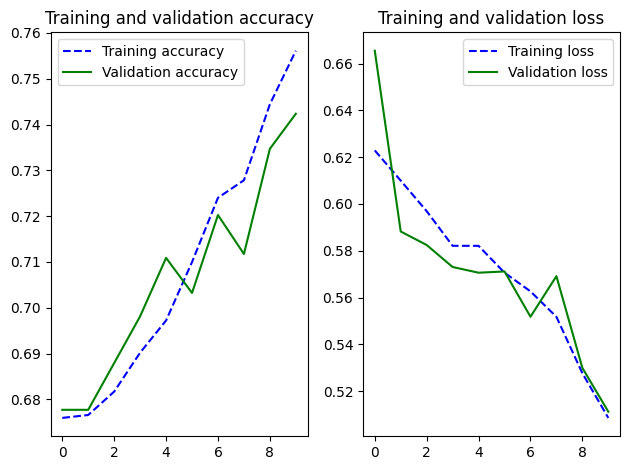

In [31]:
t_prediction_cnn_naif = Analyse_resultats(cnn_naif,cnn_naif_history)

### data augmentation

Found 4703 validated image filenames belonging to 37 classes.
Epoch 1/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 34s 214ms/step - accuracy: 0.0323 - loss: 3.6171 - val_accuracy: 0.0391 - val_loss: 3.6044
Epoch 2/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 188ms/step - accuracy: 0.0453 - loss: 3.5720 - val_accuracy: 0.0578 - val_loss: 3.4647
Epoch 3/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.0595 - loss: 3.4894 - val_accuracy: 0.0927 - val_loss: 3.3566
Epoch 4/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 153ms/step - accuracy: 0.0848 - loss: 3.4149 - val_accuracy: 0.0952 - val_loss: 3.3072
Epoch 5/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - accuracy: 0.0944 - loss: 3.3493 - val_accuracy: 0.1301 - val_loss: 3.2617
Epoch 6/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.0976 - loss: 3.2838 - val_accuracy: 0.1658 - val_loss: 3.0620
Epoch 7/15
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.1163 - loss: 3.2262 - val_accuracy: 0.1641 - val_loss: 3.0571
Epoch 8/15
147/147 ━━

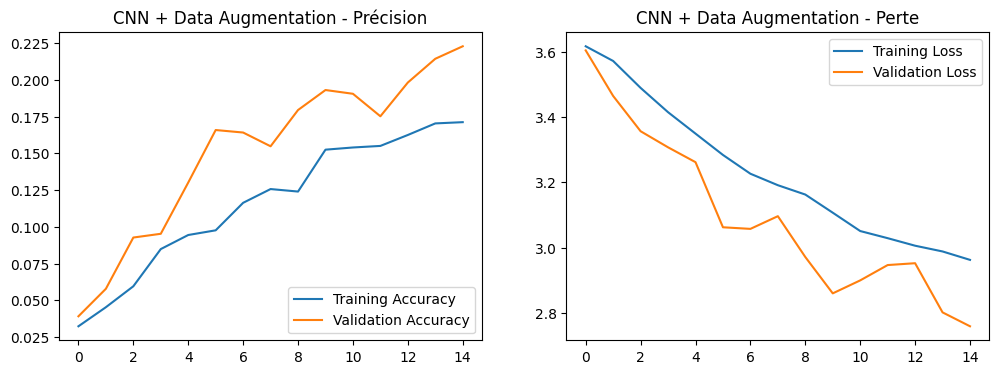

--- Évaluation finale sur le Test Set (CNN + Data Augmentation) ---
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.1959 - loss: 2.8355
Test Accuracy: 19.59%
Test Loss: 2.8355


In [ ]:
# Générateur avec Augmentation (Rotation, Zoom, Flip...)
aug_datagen = ImageDataGenerator(
    rotation_range = 10,
    rescale = 1./255,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.1,
    zoom_range = 0.1,
    brightness_range=[0.9,1.1], 
    channel_shift_range=10, 
    horizontal_flip = True,
    fill_mode='nearest'
)

# Seul le train est augmenté ! Val et Test restent "normaux"
train_gen_aug = aug_datagen.flow_from_dataframe(
    train_df, directory=img_dir, x_col='Image', y_col='BREED_NAME',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical'
)

# On réutilise le même modèle, mais entraîné sur des données augmentées
model_aug = build_simple_cnn() # On repart de zéro
history_aug = model_aug.fit(train_gen_aug, validation_data=val_gen_simple, epochs=15) # + d'epochs nécessaires

analyser_resultats(model_aug, history_aug, test_gen_simple, "CNN + Data Augmentation")

pre trained network

Epoch 1/10


2025-12-17 13:30:53.523439: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:30:53.523496: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:30:53.523512: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:30:54.110470: I external/l

 29/147 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.0171 - loss: 3.8281

2025-12-17 13:31:05.163735: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:31:05.898119: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1004', 8 bytes spill stores, 8 bytes spill loads

2025-12-17 13:31:06.051887: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1004', 288 bytes spill stores, 288 bytes spill loads



147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0294 - loss: 3.6967

2025-12-17 13:31:29.964693: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:31:30.696075: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_266', 12 bytes spill stores, 12 bytes spill loads

2025-12-17 13:31:30.726447: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_266', 12 bytes spill stores, 12 bytes spill loads

2025-12-17 13:31:30.894416: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_266', 304 byte

147/147 ━━━━━━━━━━━━━━━━━━━━ 47s 264ms/step - accuracy: 0.0453 - loss: 3.5978 - val_accuracy: 0.1088 - val_loss: 3.4020
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 178ms/step - accuracy: 0.0987 - loss: 3.3560 - val_accuracy: 0.1930 - val_loss: 3.0880
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 26s 174ms/step - accuracy: 0.1348 - loss: 3.1394 - val_accuracy: 0.2364 - val_loss: 2.8516
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 168ms/step - accuracy: 0.1818 - loss: 2.9613 - val_accuracy: 0.2696 - val_loss: 2.6713
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 167ms/step - accuracy: 0.1950 - loss: 2.8441 - val_accuracy: 0.2917 - val_loss: 2.5481
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.2192 - loss: 2.7486 - val_accuracy: 0.3282 - val_loss: 2.4659
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.2299 - loss: 2.6851 - val_accuracy: 0.3214 - val_loss: 2.3767
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.2462 - loss: 2.6198 - val

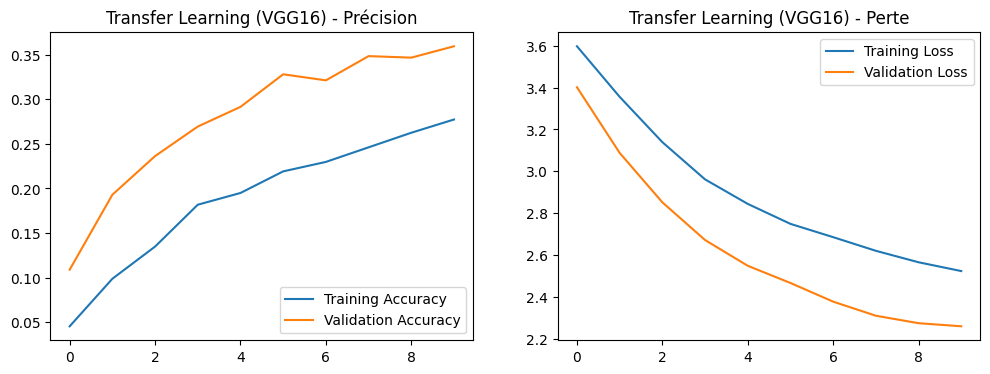

--- Évaluation finale sur le Test Set (Transfer Learning (VGG16)) ---
45/46 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3673 - loss: 2.2534

2025-12-17 13:35:12.930122: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-17 13:35:13.596468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_266', 12 bytes spill stores, 12 bytes spill loads

2025-12-17 13:35:13.975868: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_266', 304 bytes spill stores, 304 bytes spill loads



46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - accuracy: 0.3578 - loss: 2.2491
Test Accuracy: 35.78%
Test Loss: 2.2491


In [21]:
# Chargement de VGG16 sans la partie classification (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # IMPORTANT : On gèle les poids du VGG

# Ajout de notre tête de classification
inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x) # Plus efficace que Flatten
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model_transfer = Model(inputs, outputs)
model_transfer.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement (Rapide car on n'entraîne que les dernières couches)
history_transfer = model_transfer.fit(train_gen_aug, validation_data=val_gen_simple, epochs=10)

analyser_resultats(model_transfer, history_transfer, test_gen_simple, "Transfer Learning (VGG16)")

fine tuning

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.3132 - loss: 2.3564 - val_accuracy: 0.4133 - val_loss: 1.9566
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.3491 - loss: 2.1842 - val_accuracy: 0.4328 - val_loss: 1.8469
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.3787 - loss: 2.0924 - val_accuracy: 0.4405 - val_loss: 1.7740
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.3825 - loss: 2.0426 - val_accuracy: 0.4541 - val_loss: 1.7295
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.4036 - loss: 1.9625 - val_accuracy: 0.4796 - val_loss: 1.6635
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.4253 - loss: 1.9015 - val_accuracy: 0.4838 - val_loss: 1.6773
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.4355 - loss: 1.8544 - val_accuracy: 0.4855 - val_loss: 1.6761
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.4578 - loss: 1

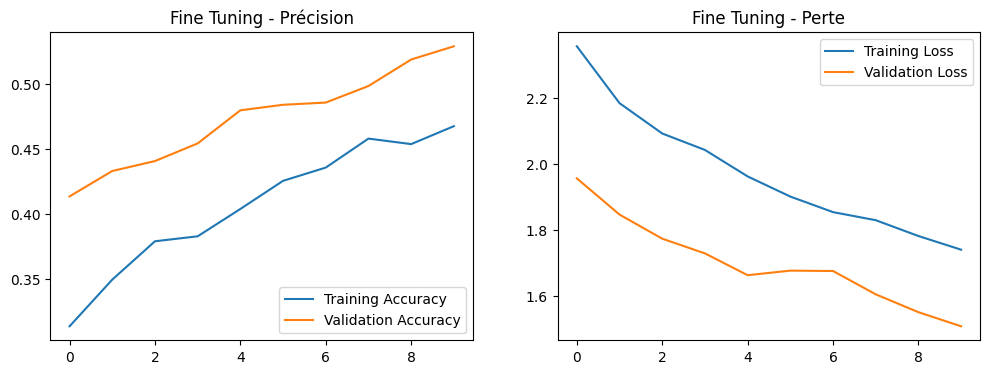

--- Évaluation finale sur le Test Set (Fine Tuning) ---
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.5279 - loss: 1.5418
Test Accuracy: 52.79%
Test Loss: 1.5418


In [22]:
# 1. Dégeler le modèle de base
base_model.trainable = True

# 2. On gèle les premières couches (garder les features génériques) et on laisse les dernières libres
# VGG16 a ~19 layers. On fine-tune à partir de la couche 15 par exemple.
for layer in base_model.layers[:15]:
    layer.trainable = False

# 3. Re-compiler avec un learning rate TRÈS faible (pour ne pas tout casser)
model_transfer.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Continuer l'entraînement
history_finetune = model_transfer.fit(train_gen_aug, validation_data=val_gen_simple, epochs=10)

analyser_resultats(model_transfer, history_finetune, test_gen_simple, "Fine Tuning")

### Classification fine

In [ ]:

# --- Paramètres ---
IMG_SIZE = (128, 128) # Réduit pour soulager le CPU/GPU
BATCH_SIZE = 32

# --- Générateurs (Data Augmentation vue en TP) ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# --- Création du flux pour les RACES (Classification Fine) ---
# Pour Chats vs Chiens, changez juste y_col="SPECIES_NAME" et class_mode="binary"
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",      # Cible : Nom de la race
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical" # 37 classes
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col="Image",
    y_col="BREED_NAME",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# --- Modèle Transfer Learning (VGG16) ---
# Comme vu dans la section "Pre-trained Network" du TP
base_model = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # On gèle les poids

# Construction du classifier
x = base_model.output
x = GlobalAveragePooling2D()(x) # Ou Flatten() comme dans le TP simple
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(37, activation='softmax')(x) # 37 neurones pour les 37 races

model_clf = Model(inputs=base_model.input, outputs=predictions)

model_clf.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# model_clf.summary()
# history_clf = model_clf.fit(train_generator, validation_data=val_generator, epochs=10)

### Segmentation

In [ ]:

class PetSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mask_dir, batch_size=32, img_size=(128, 128)):
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        images = []
        masks = []
        
        for _, row in batch_df.iterrows():
            # 1. Charger l'image
            img_path = os.path.join(self.img_dir, row['Image'])
            img = load_img(img_path, target_size=self.img_size)
            img = img_to_array(img) / 255.0 # Normalisation
            
            # 2. Charger le masque
            mask_path = os.path.join(self.mask_dir, row['mask_filename'])
            # load_img en grayscale pour avoir (H, W) et pas (H, W, 3)
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            mask = img_to_array(mask)
            
            # 3. Prétraitement du masque Oxford
            # Valeurs originales : 1 (Animal), 2 (Fond), 3 (Bordure)
            # On transforme en Binaire : 1 (Animal) vs 0 (Le reste)
            mask = np.where(mask == 1, 1.0, 0.0)
            
            images.append(img)
            masks.append(mask)
            
        return np.array(images), np.array(masks)

# Création des générateurs de segmentation
train_gen_seg = PetSegmentationGenerator(train_df, img_dir, mask_dir, BATCH_SIZE, IMG_SIZE)
val_gen_seg = PetSegmentationGenerator(val_df, img_dir, mask_dir, BATCH_SIZE, IMG_SIZE)

In [ ]:


def build_unet(input_shape):
    inputs = Input(input_shape)

    # --- Contraction (Encoder) ---
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    # --- Expansion (Decoder) ---
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = Concatenate()([u5, c3]) # Skip connection
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)

    # --- Sortie ---
    # Sigmoid car on fait une segmentation binaire (pixel = animal ou pas)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs=[inputs], outputs=[outputs])

unet_model = build_unet(IMG_SIZE + (3,))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# unet_model.summary()
# history_unet = unet_model.fit(train_gen_seg, validation_data=val_gen_seg, epochs=15)

### Pour aller plus loin

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Conv2DTranspose, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def build_multitask_model(input_shape, num_classes):
    inputs = Input(input_shape, name='input_image')

    # --- 1. ENCODEUR PARTAGÉ (Shared Backbone) ---
    # On peut utiliser un VGG16 pré-entraîné ou faire le nôtre
    # Ici, un exemple simple "From Scratch" pour bien comprendre
    
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x) # 64x64
    f1 = x # Skip connection pour la segmentation
    
    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x) # 32x32
    f2 = x 
    
    # Block 3 (Bottleneck partagé)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2))(x) # 16x16
    
    # --- 2. BRANCHE CLASSIFICATION (Tête 1) ---
    c = GlobalAveragePooling2D()(encoded) # Aplatit les features
    c = Dense(128, activation='relu')(c)
    c = Dropout(0.5)(c)
    # Sortie 1 : Classification (Nommé 'class_output')
    class_output = Dense(num_classes, activation='softmax', name='class_output')(c)

    # --- 3. BRANCHE SEGMENTATION (Tête 2 - Decoder) ---
    # On remonte la résolution comme dans un U-Net
    
    # Upsample 1
    s = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(encoded) # 32x32
    s = Concatenate()([s, f2]) # On récupère l'info spatiale de l'encodeur
    s = Conv2D(64, (3, 3), activation='relu', padding='same')(s)
    
    # Upsample 2
    s = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(s) # 64x64
    s = Concatenate()([s, f1])
    s = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    
    # Upsample 3 (Retour taille originale)
    s = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(s) # 128x128
    
    # Sortie 2 : Segmentation (Nommé 'seg_output')
    seg_output = Conv2D(1, (1, 1), activation='sigmoid', name='seg_output')(s)

    # --- MODÈLE FINAL ---
    model = Model(inputs=inputs, outputs=[class_output, seg_output])
    return model

# Création du modèle
model_joint = build_multitask_model((128, 128, 3), num_classes=37)
model_joint.summary()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array, to_categorical

class MultiTaskGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, mask_dir, batch_size, img_size, num_classes):
        self.df = df
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.num_classes = num_classes
        
        # Création d'un mapping race -> int si ce n'est pas déjà fait
        self.breeds = sorted(df['BREED_NAME'].unique())
        self.breed_to_idx = {b: i for i, b in enumerate(self.breeds)}

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        batch_df = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        class_labels = []
        masks = []
        
        for _, row in batch_df.iterrows():
            # Image
            img = load_img(os.path.join(self.img_dir, row['Image']), target_size=self.img_size)
            images.append(img_to_array(img) / 255.0)
            
            # Label Classification (One-hot encoding)
            label_idx = self.breed_to_idx[row['BREED_NAME']]
            class_labels.append(label_idx)
            
            # Masque Segmentation
            mask_path = os.path.join(self.mask_dir, row['mask_filename'])
            mask = load_img(mask_path, target_size=self.img_size, color_mode="grayscale")
            mask = img_to_array(mask)
            mask = np.where(mask == 1, 1.0, 0.0) # Binarisation
            masks.append(mask)
            
        X = np.array(images)
        y_class = to_categorical(class_labels, num_classes=self.num_classes)
        y_seg = np.array(masks)
        
        # IMPORTANT : On renvoie un dictionnaire correspondant aux noms des couches de sortie
        return X, {'class_output': y_class, 'seg_output': y_seg}

# Instanciation
train_gen_multi = MultiTaskGenerator(train_df, img_dir, mask_dir, 32, (128, 128), 37)
val_gen_multi = MultiTaskGenerator(val_df, img_dir, mask_dir, 32, (128, 128), 37)

In [ ]:
# On définit une loss différente pour chaque sortie
losses = {
    'class_output': 'categorical_crossentropy',
    'seg_output': 'binary_crossentropy' # Ou une Dice Loss personnalisée
}

# On peut donner plus d'importance à l'une ou l'autre
loss_weights = {
    'class_output': 1.0,  # Poids de la classification
    'seg_output': 1.0     # Poids de la segmentation
}

model_joint.compile(
    optimizer='adam',
    loss=losses,
    loss_weights=loss_weights,
    metrics={
        'class_output': 'accuracy', 
        'seg_output': 'accuracy' # Ou IoU
    }
)

# Entraînement
history = model_joint.fit(
    train_gen_multi,
    validation_data=val_gen_multi,
    epochs=15
)